In [152]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

In [153]:
weather_data = spark.read.csv(r'C:\dataset\weatherData\weather_data.csv', header=True, inferSchema=True)
weather_data.show(5)

+-----+-------------------+---------------+--------------+------------+--------------+-------------------+----------------+--------------+------------+-------------------+-------------------+
| City|               Date|Temperature (C)|Feels Like (C)|Humidity (%)|Pressure (hPa)|Weather Description|Wind Speed (m/s)|Cloudiness (%)|Rain (1h mm)|            Sunrise|             Sunset|
+-----+-------------------+---------------+--------------+------------+--------------+-------------------+----------------+--------------+------------+-------------------+-------------------+
|Delhi|1979-01-01 00:00:00|           9.26|          7.33|          28|          1086|              clear|            2.42|             0|        3.91|1979-01-01 06:29:00|1979-01-01 18:31:00|
|Delhi|1979-01-01 00:01:00|          14.96|         15.25|          68|           930|               cold|            1.23|            49|        5.16|1979-01-01 06:30:00|1979-01-01 18:31:00|
|Delhi|1979-01-01 00:02:00|           3.

In [154]:
#Import required Libraries
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count, when, isnan,mean
from pyspark.sql.functions import to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import avg, date_trunc
from pyspark.sql.window import Window
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DateType
from datetime import timedelta, datetime
import pandas as pd
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, GRU,SimpleRNN


In [156]:
# Assuming the DataFrame name is `weather_df` and the column is `Date`
weather_data = weather_data.withColumn("Date", F.to_date(F.col("Date"))).select('Date','Temperature (C)')

# Show the resulting DataFrame to verify
weather_data.show(4)

+----------+---------------+
|      Date|Temperature (C)|
+----------+---------------+
|1979-01-01|           9.26|
|1979-01-01|          14.96|
|1979-01-01|           3.93|
|1979-01-01|          11.46|
+----------+---------------+
only showing top 4 rows



In [157]:
# Aggregating numerical columns and rounding to 2 decimal places
final_weather_data = weather_data.groupBy("Date").agg(mean('Temperature (C)').alias("Temperature (C)")).orderBy('Date')

# Show the resulting DataFrame
final_weather_data.show(5)

+----------+------------------+
|      Date|   Temperature (C)|
+----------+------------------+
|1979-01-01| 13.32847222222223|
|1979-01-02|13.333416666666684|
|1979-01-03|13.528833333333337|
|1979-01-04|13.432513888888918|
|1979-01-05| 13.41040277777778|
+----------+------------------+
only showing top 5 rows



In [163]:
df=final_weather_data.toPandas()

In [ ]:
df=df.set_index('Date')
df.head(4)

In [164]:
df['Date'] = pd.to_datetime(df['Date'])
df=df.set_index('Date')
df.head(4)

,Temperature (C)
Date,
1979-01-01,13.328472
1979-01-02,13.333417
1979-01-03,13.528833
1979-01-04,13.432514


In [165]:
trainDF=df["2023-01-01":"2024-04-30"][['Temperature (C)']]
trainDF.head(4)

,Temperature (C)
Date,
2023-01-01,13.646854
2023-01-02,13.356340
2023-01-03,13.531757
2023-01-04,13.592799


In [166]:
validDF=df["2024-05-01":"2024-07-31"][['Temperature (C)']]
testDF=df["2024-08-01":"2024-12-31"][['Temperature (C)']]
testDF.tail(4)

,Temperature (C)
Date,
2024-10-31,30.015104
2024-11-01,13.248139
2024-11-02,13.851750
2024-11-03,13.363451


In [167]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [168]:
length=30
batch_size=1
generator=TimeseriesGenerator(trainDF.to_numpy(),trainDF.to_numpy(),length=length,batch_size=batch_size)


In [94]:
v_generator=TimeseriesGenerator(validDF.to_numpy(),validDF.to_numpy(),length=length,batch_size=batch_size)

In [95]:
X,y=generator[0]

In [96]:
X

array([[[13.64685417],
        [13.35634028],
        [13.53175694],
        [13.59279861],
        [13.54286806],
        [13.62872917],
        [13.41433333],
        [13.56252778],
        [13.42338889],
        [13.45665278],
        [13.40870833],
        [13.22560417],
        [13.58500694],
        [13.79552083],
        [13.3135625 ],
        [13.78759028],
        [13.45129861],
        [13.55849306],
        [13.25152083],
        [13.4795625 ],
        [13.34944444],
        [13.41608333],
        [13.47752778],
        [13.5718125 ],
        [13.66966667],
        [13.75010417],
        [13.60811111],
        [13.59699306],
        [14.08741667],
        [13.21000694]]])

In [97]:
y

array([[13.50989583]])

In [98]:
X,y=generator[1]
X

array([[[13.35634028],
        [13.53175694],
        [13.59279861],
        [13.54286806],
        [13.62872917],
        [13.41433333],
        [13.56252778],
        [13.42338889],
        [13.45665278],
        [13.40870833],
        [13.22560417],
        [13.58500694],
        [13.79552083],
        [13.3135625 ],
        [13.78759028],
        [13.45129861],
        [13.55849306],
        [13.25152083],
        [13.4795625 ],
        [13.34944444],
        [13.41608333],
        [13.47752778],
        [13.5718125 ],
        [13.66966667],
        [13.75010417],
        [13.60811111],
        [13.59699306],
        [14.08741667],
        [13.21000694],
        [13.50989583]]])

In [99]:
X.shape

(1, 30, 1)

In [100]:
y

array([[13.27096528]])

In [101]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, GRU,SimpleRNN


In [102]:
model=Sequential()
#model.add(LSTM(32,input_shape=[10,1],return_sequences=True))
model.add(GRU(32,input_shape=[length,1]))
model.add(Dense(1))

In [103]:
model.compile(optimizer="adam", loss="mse")

In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                3360      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3393 (13.25 KB)
Trainable params: 3393 (13.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=3)


In [106]:
history=model.fit(generator,validation_data=v_generator,epochs=100,callbacks=[early_stop])

Epoch 1/100
456/456 [==============================] - 9s 16ms/step - loss: 480.4730 - val_loss: 334.6712
Epoch 2/100
456/456 [==============================] - 7s 15ms/step - loss: 154.9441 - val_loss: 109.0903
Epoch 3/100
456/456 [==============================] - 7s 15ms/step - loss: 51.2405 - val_loss: 31.5239
Epoch 4/100
456/456 [==============================] - 7s 14ms/step - loss: 19.5634 - val_loss: 12.6921
Epoch 5/100
456/456 [==============================] - 7s 15ms/step - loss: 8.8898 - val_loss: 3.8267
Epoch 6/100
456/456 [==============================] - 7s 15ms/step - loss: 5.0113 - val_loss: 1.8126
Epoch 7/100
456/456 [==============================] - 6s 14ms/step - loss: 3.8634 - val_loss: 1.7730
Epoch 8/100
456/456 [==============================] - 7s 14ms/step - loss: 3.5149 - val_loss: 1.2833
Epoch 9/100
456/456 [==============================] - 6s 14ms/step - loss: 3.5020 - val_loss: 1.2595
Epoch 10/100
456/456 [==============================] - 6s 14ms/step -

In [107]:
d=pd.DataFrame(model.history.history)

<Axes: >

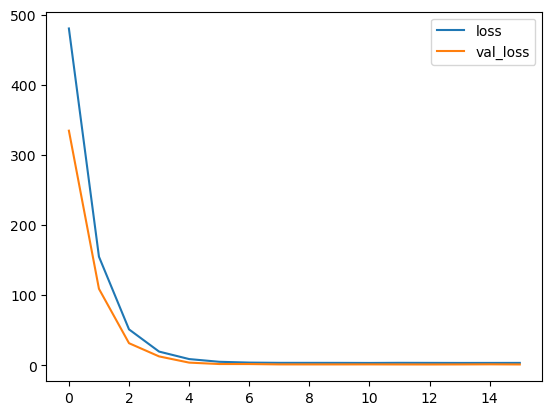

In [108]:
import matplotlib.pyplot as plt
d.plot()

In [109]:
first_eval=validDF[-length:]


In [110]:
first_eval

,Temperature (C)
Date,
2024-07-02,30.091965
2024-07-03,29.997340
2024-07-04,30.031979
2024-07-05,29.846924
2024-07-06,30.088514
2024-07-07,29.991625
2024-07-08,30.074639
2024-07-09,29.901632
2024-07-10,30.047889


In [111]:
current_eval=first_eval.to_numpy().reshape((1,length,1))

In [112]:
current_eval

array([[[30.09196528],
        [29.99734028],
        [30.03197917],
        [29.84692361],
        [30.08851389],
        [29.991625  ],
        [30.07463889],
        [29.90163194],
        [30.04788889],
        [30.03481944],
        [30.03454167],
        [30.0875    ],
        [30.14376389],
        [29.97786111],
        [29.97065278],
        [30.10164583],
        [29.96322917],
        [29.84975   ],
        [30.00579861],
        [29.99190972],
        [29.93122222],
        [29.94678472],
        [29.94911806],
        [29.99234028],
        [30.04151389],
        [29.99636806],
        [30.02224306],
        [30.04519444],
        [30.18740972],
        [30.04215278]]])

In [135]:
import numpy as np
test_pred=[]
for i in range(95):
    curr_pred=model.predict(current_eval)[0]
    test_pred.append(curr_pred)
    current_eval=np.append(current_eval[:,1:,:],[[testDF.to_numpy()[i]]],axis=1)

1/1 [==============================] - 0s 51ms/step


In [138]:
testDF['predict']=test_pred

In [139]:
testDF.tail(20)

,Temperature (C),predict
Date,,
2024-10-15,30.067431,[30.117434]
2024-10-16,30.089347,[30.143284]
2024-10-17,30.051715,[30.150787]
2024-10-18,29.902694,[30.141916]
2024-10-19,29.979285,[30.104305]
2024-10-20,30.075319,[30.120155]
2024-10-21,29.976806,[30.14547]
2024-10-22,30.027403,[30.123066]
2024-10-23,30.013569,[30.133583]


In [140]:
testDF.head(20)

,Temperature (C),predict
Date,,
2024-08-01,30.066000,[15.677303]
2024-08-02,30.062354,[34.93996]
2024-08-03,29.984583,[35.282745]
2024-08-04,29.955604,[32.008415]
2024-08-05,30.040583,[30.478853]
2024-08-06,29.952792,[30.171059]
2024-08-07,29.907819,[30.11733]
2024-08-08,30.097889,[30.103207]
2024-08-09,30.018306,[30.149681]


In [141]:
testDF.to_csv(r'C:\dataset\weatherData\predict_data.csv')

In [146]:
first_eval_fut=testDF[-length:]
current_eval_fut=first_eval_fut.to_numpy().reshape((1,length,1))

In [147]:
current_eval_fut

array([[[29.98329167],
        [30.058375  ],
        [29.99774306],
        [29.93038889],
        [29.88575694],
        [29.93281944],
        [30.10590972],
        [30.11072222],
        [29.89670139],
        [29.96867361],
        [30.06743056],
        [30.08934722],
        [30.05171528],
        [29.90269444],
        [29.97928472],
        [30.07531944],
        [29.97680556],
        [30.02740278],
        [30.01356944],
        [30.03490972],
        [29.98445833],
        [30.05414583],
        [29.92615972],
        [30.03183333],
        [29.96413194],
        [30.01284722],
        [30.01510417],
        [13.24813889],
        [13.85175   ],
        [13.36345139]]])

In [148]:
import numpy as np
test_pred_fut=[]
for i in range(95):
    curr_pred_fut=model.predict(current_eval_fut)[0]
    test_pred_fut.append(curr_pred_fut)
    current_eval_fut=np.append(current_eval[:,1:,:],[[curr_pred_fut]],axis=1)

1/1 [==============================] - 0s 43ms/step


In [151]:
df_fut=pd.DataFrame(test_pred_fut)
df_fut.to_csv(r'C:\dataset\weatherData\predict_data_fut.csv')